In [51]:
seed = 42
import pandas as pd
import numpy as np
import random
np.random.seed(seed)
random.seed(seed)

Load the data

In [52]:
data = pd.read_csv('data/EEG_data.csv')
data.columns

"""
load subtitle vectors  
"""
sub_vec_path = 'data/subtitles/subtitle_vecs.npy'
sub_vecs = np.load(sub_vec_path)
sub_vec_dim = sub_vecs.shape[1]

"""
Make a dataset of original data combined with sub vecs 
"""
dataset = np.hstack((data.values.astype('float32'), sub_vecs))


PCA to reduce dimension of the word average vectors (might give better results) to reduce training speed

In [53]:
from sklearn.decomposition import PCA

sub_vec_dim = 12
pca = PCA(n_components=sub_vec_dim)
pcad_sub_vecs = pca.fit_transform(sub_vecs)
dataset = np.hstack((data.values.astype('float32'), pcad_sub_vecs))

Define target variable and training variables

In [54]:
# The student's confusion column index is 14, predefined label index is 13
y_col = 13
orig_train_data_cols = list(range(2,y_col))
vector_cols = list(np.arange(sub_vec_dim) + 15) 

train_cols = orig_train_data_cols #+ vector_cols
n_dims = len(train_cols)

Functions to make interval counts even for all data points

In [55]:
def min_max_rows_per_subject_vid(X):
    VideoID = list(set(X[:,1]))
    SubjectID = list(set(X[:,0]))

    max_intervals = 0 # length of signal
    min_intervals = len(X)

    for subId in SubjectID:
        for vidId in VideoID:
            X_tmp=X[(X[:, 0] == subId) & (X[:, 1] == vidId)]
            max_intervals = max(len(X_tmp), max_intervals)
            min_intervals = min(len(X_tmp), min_intervals)
    print(max_intervals)
    print(min_intervals)
    assert max_intervals == 144
    return min_intervals, max_intervals

min_intervals, max_intervals = min_max_rows_per_subject_vid(dataset)



def zero_pad_data(data, max_intervals, train_cols, y_col):
    X_pad = None
    y = []
    VideoID = list(set(data[:,1]))
    SubjectID = list(set(data[:,0])) 
    for subId in SubjectID:
        for vidId in VideoID:
            data_sv = data[(data[:,0]==subId) & (data[:,1]==vidId)]

            y.append(data_sv[:, y_col].mean())

            X_sv = data_sv[:, train_cols]
            
            pad_len = max_intervals - X_sv.shape[0]
    
            z = np.zeros((pad_len, X_sv.shape[1]), dtype=X_sv.dtype)
            z[:,0] = X_sv[:,0][pad_len]
            z[:,1] = X_sv[:,1][pad_len]
            
            X_sv_pad = np.concatenate((X_sv, z), axis=0)
            X_sv_pad = X_sv_pad.reshape(1, -1)

            X_pad = X_sv_pad if X_pad is None else np.vstack((X_pad, X_sv_pad))
            
    return X_pad, np.array(y)

def truncate_data(data, min_intervals, train_cols, y_col):
    X_trunc = None
    y = []
    VideoID = list(set(data[:,1]))
    SubjectID = list(set(data[:,0]))
    for vidId in VideoID:
        for subId in SubjectID:
            data_sv = data[(data[:,0]==subId) & (data[:,1]==vidId)]
 
            y.append(data_sv[:, y_col].mean())

            X_sv = data_sv[:, train_cols]
            trunc_len = min_intervals
            X_sv_trunc = X_sv[0:trunc_len].reshape(1, -1)
            X_trunc = X_sv_trunc if X_trunc is None else np.vstack((X_trunc, X_sv_trunc))
    return X_trunc, np.array(y)

144
112


In [56]:
"""
Cross-validate
"""
from time import time
from sklearn.metrics import precision_recall_fscore_support as pr_f1, accuracy_score as accur, matthews_corrcoef, \
roc_auc_score
from sklearn.base import clone, BaseEstimator
from time import time
import numpy as np

def get_scores(modelname, y, y_hat):
    acc = accur(y, y_hat)
    matt = matthews_corrcoef(y, y_hat)
    p, r, f1, sup = pr_f1(y, y_hat)
    roc_auc = roc_auc_score(y, y_hat)
    return acc, f1[1], f1[0], roc_auc

def sklearn_cross_validate(modelname, model, data, intervals, even_data, n_test=2):
    """
    even_data: either truncate_data or zero_pad_data to make number of intervals
             even for each data point
    """
    results = []
    start = time()
    for i in range(0, 10, n_test):
        cv_model = clone(model)
        
        
        X_train, y_train = even_data(data[np.in1d(data[:,0], (i, i+1), invert=True)],
                                     intervals, train_cols, y_col)
        X_test, y_test = even_data(data[np.in1d(data[:,0], (i, i+1))],
                                   intervals, train_cols, y_col)
        
        print(X_train.shape)
        #print(y_test)
        cv_model.fit(X_train, y_train)
        
        print('{}-fold cross validation for model {}, iteration {}'
              .format(int(10/n_test), modelname, len(results) +1))
        acc, f1, f1_flip, roc_auc = get_scores('svm', y_test, np.round(cv_model.predict(X_test)))

        results.append({'acc': acc, 'F1': f1, 'F1-flipped': f1_flip, 'roc-auc': roc_auc})
        result_means = {key:np.mean([r[key] for r in results]) for key in results[0].keys()}
        print('current cross-validation mean accuracy: {:.3f}, f1: {:.3f}, f1 flipped: {:.3f} and roc-auc: {:.3f}'.format(
              *result_means.values()))
    print('cross-validation total time: {:.3f} seconds'.format(time() - start))
    return result_means, results


Test cross-validation with Support Vector Classifier

In [57]:
print(dataset.shape)
from sklearn.svm import SVC
model = SVC(C=1, kernel='linear')
result_means, results = sklearn_cross_validate('svc', model, dataset, max_intervals, zero_pad_data)

(12811, 27)
(80, 1584)
5-fold cross validation for model svc, iteration 1
current cross-validation mean accuracy: 0.650, f1: 0.667, f1 flipped: 0.632 and roc-auc: 0.650
(80, 1584)
5-fold cross validation for model svc, iteration 2
current cross-validation mean accuracy: 0.625, f1: 0.679, f1 flipped: 0.530 and roc-auc: 0.625
(80, 1584)
5-fold cross validation for model svc, iteration 3
current cross-validation mean accuracy: 0.617, f1: 0.638, f1 flipped: 0.566 and roc-auc: 0.617
(80, 1584)
5-fold cross validation for model svc, iteration 4
current cross-validation mean accuracy: 0.613, f1: 0.618, f1 flipped: 0.583 and roc-auc: 0.612
(80, 1584)
5-fold cross validation for model svc, iteration 5
current cross-validation mean accuracy: 0.640, f1: 0.654, f1 flipped: 0.600 and roc-auc: 0.640
cross-validation total time: 0.151 seconds


Helper functions to save models in a format that can be used to create a pandas DataFrame

In [58]:
def init_scores():
    return {'Model':[], 'Accuracy':[], 'F1':[], 'F1 flipped':[], 'ROC-AUC':[]}

def save_model_score(scores, name, results):
    scores['Model'].append(name)
    scores['Accuracy'].append(results['acc'])
    scores['F1'].append(results['F1'])
    scores['F1 flipped'].append(results['F1-flipped'])
    scores['ROC-AUC'].append(results['roc-auc'])

In [59]:
class Naive(BaseEstimator):
    def __init__(self):
        self.X = None
        self.y = None
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, X):
        return np.zeros(len(X))
    
    def predict_proba(self, X):
        return np.zeros(len(X))
    
    def decision_function(self, X):
        return np.zeros(len(X))

Perform cross-validation on multiple models 

In [60]:
import warnings

def warn(*args, **kwargs):
    pass

old_warn = warnings.warn
warnings.warn = warn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import linear_model as lm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.model_selection import cross_val_score

scores = init_scores()
sk_scores = init_scores()

seed = np.random.randint(0, 2000)
models = {'Naive': Naive(),
          'Logreg': lm.LogisticRegression(random_state=seed),
          'Ptron': lm.Perceptron(random_state=seed),
          'KNN': KNeighborsClassifier(n_neighbors=5),
          'GNB': GaussianNB(),
          'BNB': BernoulliNB(),
          'RF': RandomForestClassifier(random_state=seed),
          'GBT': GradientBoostingClassifier(n_estimators=777,
                                            random_state=seed),
          'MLP2': MLP(hidden_layer_sizes=((32,)*2), random_state=seed,
                       solver='adam', activation='logistic'),
          'MLP3': MLP(hidden_layer_sizes=((16, 8, 16)), random_state=seed,
                       solver='adam', activation='logistic'),
          'SVC Linear': SVC(C=1, kernel='linear', random_state=seed)}

for name, model in models.items():
    result_means, results = sklearn_cross_validate(name, model, dataset, max_intervals, zero_pad_data)
    save_model_score(scores, name, result_means)
    X, y = zero_pad_data(dataset, max_intervals, train_cols, y_col)
    result_means={key:np.mean(cross_val_score(model, X,y, cv=5, n_jobs=-1, scoring=metric))
                  for key, metric in {'F1':'f1', 'acc':'accuracy'}.items()}
    result_means['F1-flipped'] = 0.
    result_means['roc-auc'] = 0.
    save_model_score(sk_scores, name, result_means)

(80, 1584)
5-fold cross validation for model Naive, iteration 1
current cross-validation mean accuracy: 0.500, f1: 0.000, f1 flipped: 0.667 and roc-auc: 0.500
(80, 1584)
5-fold cross validation for model Naive, iteration 2
current cross-validation mean accuracy: 0.500, f1: 0.000, f1 flipped: 0.667 and roc-auc: 0.500
(80, 1584)
5-fold cross validation for model Naive, iteration 3
current cross-validation mean accuracy: 0.500, f1: 0.000, f1 flipped: 0.667 and roc-auc: 0.500
(80, 1584)
5-fold cross validation for model Naive, iteration 4
current cross-validation mean accuracy: 0.500, f1: 0.000, f1 flipped: 0.667 and roc-auc: 0.500
(80, 1584)
5-fold cross validation for model Naive, iteration 5
current cross-validation mean accuracy: 0.500, f1: 0.000, f1 flipped: 0.667 and roc-auc: 0.500
cross-validation total time: 0.096 seconds


/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(80, 1584)
5-fold cross validation for model Logreg, iteration 1
current cross-validation mean accuracy: 0.550, f1: 0.609, f1 flipped: 0.471 and roc-auc: 0.550
(80, 1584)
5-fold cross validation for model Logreg, iteration 2
current cross-validation mean accuracy: 0.600, f1: 0.638, f1 flipped: 0.551 and roc-auc: 0.600
(80, 1584)
5-fold cross validation for model Logreg, iteration 3
current cross-validation mean accuracy: 0.600, f1: 0.610, f1 flipped: 0.580 and roc-auc: 0.600
(80, 1584)
5-fold cross validation for model Logreg, iteration 4
current cross-validation mean accuracy: 0.613, f1: 0.616, f1 flipped: 0.601 and roc-auc: 0.613
(80, 1584)
5-fold cross validation for model Logreg, iteration 5
current cross-validation mean accuracy: 0.630, f1: 0.638, f1 flipped: 0.614 and roc-auc: 0.630
cross-validation total time: 0.404 seconds
(80, 1584)
5-fold cross validation for model Ptron, iteration 1
current cross-validation mean accuracy: 0.550, f1: 0.667, f1 flipped: 0.308 and roc-auc: 0.55

/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


5-fold cross validation for model MLP3, iteration 2
current cross-validation mean accuracy: 0.500, f1: 0.667, f1 flipped: 0.000 and roc-auc: 0.500
(80, 1584)
5-fold cross validation for model MLP3, iteration 3
current cross-validation mean accuracy: 0.500, f1: 0.667, f1 flipped: 0.000 and roc-auc: 0.500
(80, 1584)


/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


5-fold cross validation for model MLP3, iteration 4
current cross-validation mean accuracy: 0.500, f1: 0.667, f1 flipped: 0.000 and roc-auc: 0.500
(80, 1584)
5-fold cross validation for model MLP3, iteration 5
current cross-validation mean accuracy: 0.500, f1: 0.667, f1 flipped: 0.000 and roc-auc: 0.500
cross-validation total time: 0.840 seconds


/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(80, 1584)
5-fold cross validation for model SVC Linear, iteration 1
current cross-validation mean accuracy: 0.650, f1: 0.667, f1 flipped: 0.632 and roc-auc: 0.650
(80, 1584)
5-fold cross validation for model SVC Linear, iteration 2
current cross-validation mean accuracy: 0.625, f1: 0.679, f1 flipped: 0.530 and roc-auc: 0.625
(80, 1584)
5-fold cross validation for model SVC Linear, iteration 3
current cross-validation mean accuracy: 0.617, f1: 0.638, f1 flipped: 0.566 and roc-auc: 0.617
(80, 1584)
5-fold cross validation for model SVC Linear, iteration 4
current cross-validation mean accuracy: 0.613, f1: 0.618, f1 flipped: 0.583 and roc-auc: 0.612
(80, 1584)
5-fold cross validation for model SVC Linear, iteration 5
current cross-validation mean accuracy: 0.640, f1: 0.654, f1 flipped: 0.600 and roc-auc: 0.640
cross-validation total time: 0.139 seconds


Plot the results

         Model  Accuracy        F1  F1 flipped  ROC-AUC
0        Naive      0.50  0.000000    0.666667     0.50
1       Logreg      0.63  0.637954    0.614373     0.63
2        Ptron      0.66  0.675742    0.615406     0.66
3          KNN      0.56  0.639117    0.415556     0.56
4          GNB      0.75  0.759883    0.727675     0.75
5          BNB      0.73  0.733818    0.713640     0.73
6           RF      0.79  0.800331    0.776966     0.79
7          GBT      0.77  0.777835    0.760702     0.77
8         MLP2      0.49  0.193140    0.625518     0.49
9         MLP3      0.50  0.666667    0.000000     0.50
10  SVC Linear      0.64  0.654017    0.599909     0.64
['Naive' 'Logreg' 'Ptron' 'KNN' 'GNB' 'BNB' 'RF' 'GBT' 'MLP2' 'MLP3'
 'SVC Linear']


<IPython.core.display.Javascript object>


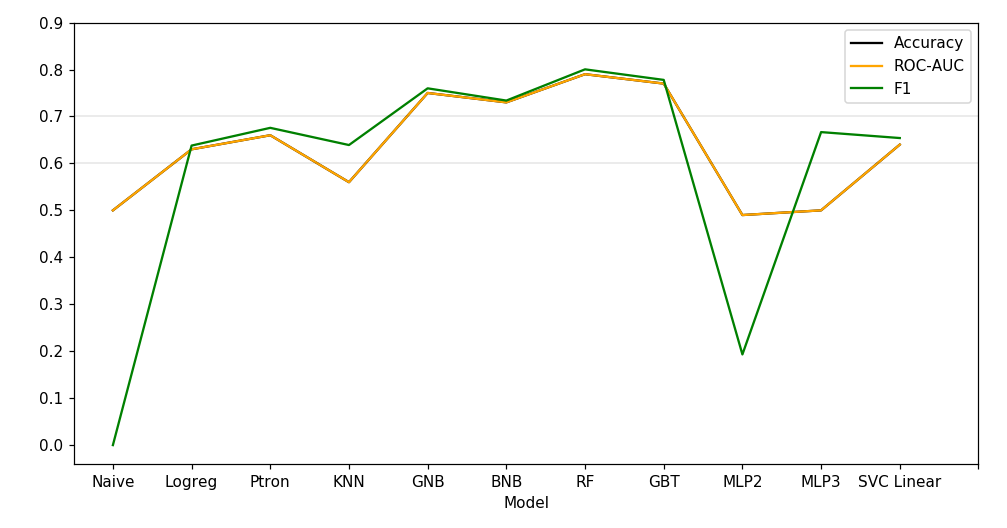

In [61]:
%matplotlib notebook
from matplotlib import pyplot as plt

scores_df = pd.DataFrame(data=scores)
print(scores_df)
print(scores_df.Model.values)


ax = scores_df.plot(kind='line', x='Model', y=['Accuracy', 'ROC-AUC', 'F1'], xticks=range(len(models) + 1),
                    yticks=np.arange(10) / 10, color=['black', 'orange', 'green'])
ax.set_xticklabels(list(scores_df.Model))
for p in ax.patches:
     ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.02))
ax.axhline(y=0.7, xmin=0.0, xmax=1.0, color='black', linewidth=.1)
ax.axhline(y=0.6, xmin=0.0, xmax=1.0, color='black', linewidth=.1)
plt.tight_layout()
plt.show()

         Model  Accuracy        F1  F1 flipped  ROC-AUC
0        Naive      0.50  0.000000         0.0      0.0
1       Logreg      0.63  0.637954         0.0      0.0
2        Ptron      0.66  0.675742         0.0      0.0
3          KNN      0.56  0.639117         0.0      0.0
4          GNB      0.75  0.759883         0.0      0.0
5          BNB      0.73  0.733818         0.0      0.0
6           RF      0.79  0.800331         0.0      0.0
7          GBT      0.77  0.777835         0.0      0.0
8         MLP2      0.49  0.193140         0.0      0.0
9         MLP3      0.50  0.666667         0.0      0.0
10  SVC Linear      0.64  0.654017         0.0      0.0
['Naive' 'Logreg' 'Ptron' 'KNN' 'GNB' 'BNB' 'RF' 'GBT' 'MLP2' 'MLP3'
 'SVC Linear']


<IPython.core.display.Javascript object>


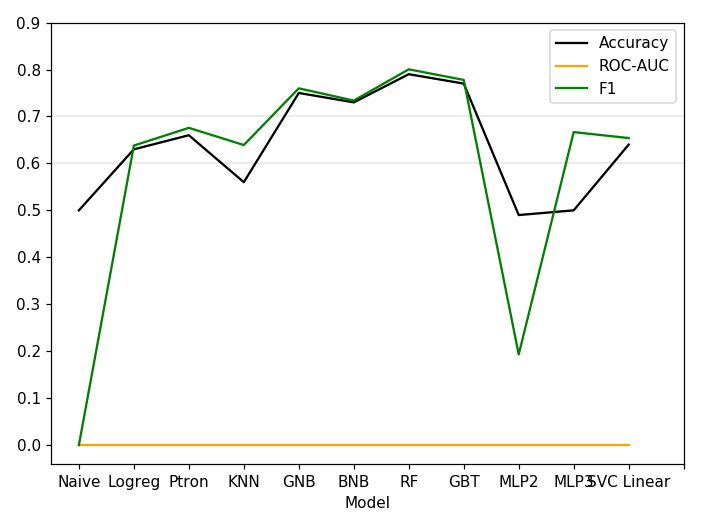

In [62]:
scores_df = pd.DataFrame(data=sk_scores)
print(scores_df)
print(scores_df.Model.values)


ax = scores_df.plot(kind='line', x='Model', y=['Accuracy', 'ROC-AUC', 'F1'], xticks=range(len(models) + 1),
                    yticks=np.arange(10) / 10, color=['black', 'orange', 'green'])
ax.set_xticklabels(list(scores_df.Model))
for p in ax.patches:
     ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.02))
ax.axhline(y=0.7, xmin=0.0, xmax=1.0, color='black', linewidth=.1)
ax.axhline(y=0.6, xmin=0.0, xmax=1.0, color='black', linewidth=.1)
plt.tight_layout()
plt.show()

In [63]:
print(dataset.shape)
print(len(train_cols))

(12811, 27)
11
